In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from nmjmc.nn import (
    NeuralMJMCLoss,
    NeuralMJMCNetwork,
    TrainNetworkBiased,
    BiasedPotentialLoss,
)
from nmjmc.systems import RepulsiveParticles

# Set up system and network

In [ ]:
parameters = {
    "nsolvent": 36,
    "temperature": 1.0,
    "eps": 1.0,  # LJ prefactor
    "rm": 1.0,  # LJ particle size
    "dimer_slope": 0.0,  # dimer slope parameter
    "dimer_a": 25.0,  # dimer x2 parameter
    "dimer_b": 10.0,  # dimer x4 parameter
    "dimer_dmid": 1.5,  # dimer transition state distance
    "dimer_k": 20.0,  # dimer force constant
    "box_halfsize": 3.0,
    "box_k": 100.0,  # box repulsion force constant
    "grid_k": 0.0,  # restraint strength to particle grid (to avoid permutation)
}


In [ ]:
references = np.load("../local_data/particles_reference_configurations.npz")
reference_open = references["reference_open"]
reference_closed = references["reference_closed"]
# run NMJMC_particles_generate_dataset.ipynb first to generate training set
biased_confs = np.load(
    "../local_data/training_data_particles_biased.npz", allow_pickle=True
)
particle_system = RepulsiveParticles(params=biased_confs["params"].tolist())

In [ ]:
class HarmonicBias:
    def __init__(self, reference_open, reference_closed, k_bias=5, dimer_split=1.5):
        self.reference_open = reference_open
        self.reference_closed = reference_closed
        self.k_bias = k_bias
        self.dimer_split = dimer_split

    def energy_bias(self, x):
        split = np.linalg.norm(x[:, :2] - x[:, 2:4], axis=1)
        idcs_open = np.where(split > self.dimer_split)[0]
        idcs_closed = np.where(split < self.dimer_split)[0]
        E_bias = np.zeros(len(x))
        E_bias[idcs_open] = np.sum((x[idcs_open] - self.reference_open) ** 2, axis=1)
        E_bias[idcs_closed] = np.sum(
            (x[idcs_closed] - self.reference_closed) ** 2, axis=1
        )
        return self.k_bias * E_bias

    def energy_bias_tf(self, x):
        split = tf.norm(x[:, :2] - x[:, 2:4], axis=1)
        E_bias_open = tf.reduce_sum((x - self.reference_open) ** 2, axis=1)
        E_bias_closed = tf.reduce_sum((x - self.reference_closed) ** 2, axis=1)
        E_bias = tf.where(split > self.dimer_split, E_bias_open, E_bias_closed)
        return self.k_bias * E_bias

    def energy(self, x):
        return self.energy_bias(x)

    def energy_tf(self, x):
        return self.energy_bias_tf(x)

In [ ]:
leakyRelu = tf.keras.layers.LeakyReLU(alpha=0.1)


def split_cond(x, dimer_split):
    return tf.abs(x[:, 0] - x[:, 2]) < dimer_split


dim = 76
t_nodes = [dim] * 3
s_nodes = [dim] * 3
nnodes_sigma = [dim, dim, dim]
nnicer = 20

nn = NeuralMJMCNetwork(
    s_nodes,
    t_nodes,
    nnicer,
    layer_activation=leakyRelu,
    split_cond=split_cond,
    system=particle_system,
)
nn.trainable_rnvp(True)

# Load data and train

In [ ]:
# use unbiased configurations for validation
validation_data = np.concatenate(
    [biased_confs["samples_open"][-1, ::10], biased_confs["samples_closed"][-1, ::10]]
)
training_schedule = [
    {
        "init_training": True,
        "n_epochs": 10,
        "clipnorm": None,
        "learning_rate": 0.001,
        "training_set": 0,
        "bias_strength": 500.0,
    },
    {
        "init_training": False,
        "n_epochs": 200,
        "clipnorm": None,
        "learning_rate": 0.001,
        "training_set": 6,
        "bias_strength": 10.0,
    },
    {
        "init_training": False,
        "n_epochs": 500,
        "clipnorm": None,
        "learning_rate": 0.0001,
        "training_set": 7,
        "bias_strength": 5.0,
    },
    {
        "init_training": False,
        "n_epochs": 10000,
        "clipnorm": 10000.0,
        "learning_rate": 0.00001,
        "training_set": 8,
        "bias_strength": 2.0,
    },
    {
        "init_training": False,
        "n_epochs": 10000,
        "clipnorm": 0.1,
        "learning_rate": 0.0001,
        "training_set": 8,
        "bias_strength": 0.0,
    },
]

In [ ]:
for schedule in training_schedule:
    i = schedule["training_set"]
    k = schedule["bias_strength"]
    particles_bias = HarmonicBias(reference_open, reference_closed, k_bias=k)
    loss = BiasedPotentialLoss(particle_system, particles_bias, nn)
    confs_open = biased_confs["samples_open"][i]
    confs_closed = biased_confs["samples_closed"][i]
    trainer = TrainNetworkBiased(
        nn,
        particle_system,
        particles_bias,
        loss,
        confs_open,
        confs_closed,
        reference_open,
        reference_closed,
        validation_data,
    )
    if schedule["init_training"]:
        trainer.train_init(5, 10000)
    if schedule["n_epochs"] > 0:
        trainer.train(
            schedule["n_epochs"], schedule["clipnorm"], batchsize=8192, lr=schedule["learning_rate"]
        )

In [ ]:
nn.save_weights('../local_data/particles_weights.h5')

# Show some examples

delta energy: [2.8315496]
log Jacobian -4.692166
Pacc:  [0.00054012]


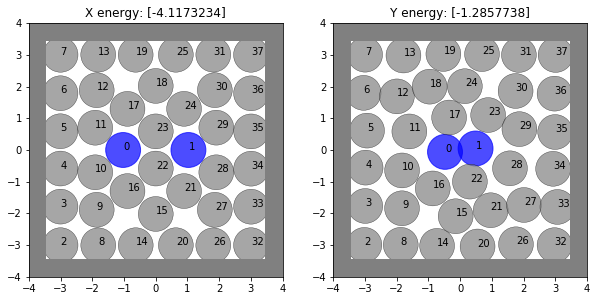

<IPython.core.display.Javascript object>

In [11]:
nmjmc.draw_mjmc(nn, particle_system.energy, reference_open, verbose=1)

delta energy: [2.2380128]
log Jacobian -4.85144
Pacc:  [0.00083385]


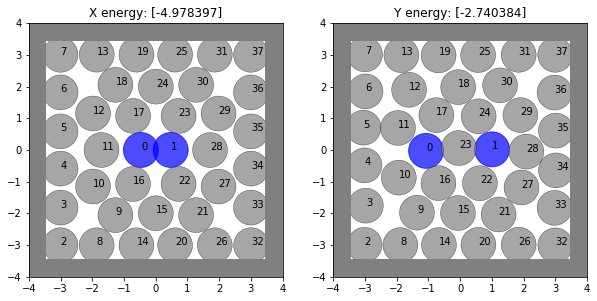

<IPython.core.display.Javascript object>

In [29]:
nmjmc.draw_mjmc(nn, particle_system.energy, reference_closed, verbose=1)

delta energy: [4.770046]
log Jacobian -4.9191036
Pacc:  [6.195205e-05]


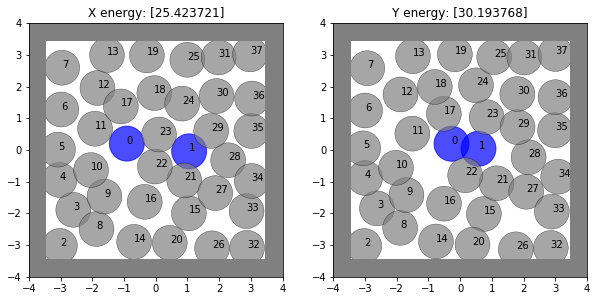

<IPython.core.display.Javascript object>

In [32]:
nmjmc.draw_mjmc(nn, particle_system.energy, validation_data[200], verbose=1)

delta energy: [6.5305843]
log Jacobian -6.1580114
Pacc:  [3.0861206e-06]


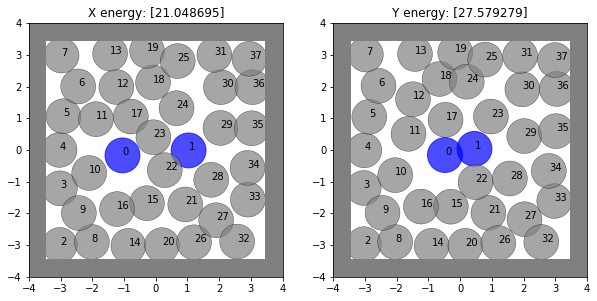

<IPython.core.display.Javascript object>

In [33]:
nmjmc.draw_mjmc(nn, particle_system.energy, validation_data[-200], verbose=1)